<a href="https://colab.research.google.com/github/Jakewilliamshort/EMAT-Preliminary-Report/blob/main/Numerically_Solved_Equation_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Numerically Solved Equation 17

'Import essential Packages'

In [1]:
import pandas as pd
import numpy as np
##import math as ma
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
#import sympy as sy
##import scipy as sp
#from scipy.integrate import odeint

'ode solver'
from scipy.integrate import solve_ivp

'function driven, numerical integration '
##from scipy.integrate import quad

'series type, numerical integration '
#from scipy.integrate import trapezoid
from scipy.integrate import simpson


'This set the orginal constants'

In [2]:
#from scipy.integrate import cumulative_trapezoid

#according to 10025 on 'Frontal Photopolymerization for Microfluidic Applications' paper:
#μ = μ_0*(1 - ϕ) + μ_infny*ϕ 
#ϕ = 0.05
#μ = 1*(1 - 0.05) + 5*0.05
#photodarkening process using the realistic model parameters

μ_0 = 1
μ_infny = 1
kI_0 = 0.0015

'Define mu function'

In [3]:
def μ(ϕ, μ_0, μ_infny):
    return μ_0*(1 - ϕ) + μ_infny*ϕ 

'Set up required vectors'

In [4]:
#'Number of z nodes in the z axis'
z_nodes = 100
#Set the initial conditions as a vector of `z_nodes` number of zeros. Vector is required because its creating an array and isnt a scalar (A scalar variable, or scalar field, is a variable that holds one value at a time.). 
#this is where ϕ values are stored
ϕ_vec = np.zeros(z_nodes)

#linspace from 0 to 1.15 with `z_nodes` number of increment inbetween.
#change how far it calculates the z propagation. currently 0 to 1.15mm.      
z = np.linspace(0, 1.5, z_nodes)


'Set up numerical intergration function'

In [5]:
def Numerical_integration_term(ϕ_vec,
                               z_vec = z, 
                               mu_pass = μ, 
                               μ_0 = μ_0, 
                               μ_infny = μ_infny):
    '''
    Parameters
    ----------
    ϕ_vec : np.array or list type
    
        phi_vec gets updated each time step in ODE solver, labelled _vec to remind 
        that it is a list (vector-array) of phi values corresponding (element wise)
        to the `z` coordinates in z_vec..
    
    z_vec : np.array or list type, optional[unless z space changes with time]
        Is vector-array (list) of z position values, which correspond (element-wise)
        to those in phi vector
        The default is z.
    
    mu_pass=μ : function, optional
        function for computing mu value; returns double scalar. The default is μ.
    μ_0 : scalar number (double precision), optional
        Constant term input. The default is μ_0.
    μ_infny : scalar number (double precision), optional
        Constant term input. The default is μ_infny.

    Returns
    -------
    int_vec : TYPE
        This is the returned integral term vector array.
        The i^th element corresponds to integration of `mu` up to `z[i]` and
        mu is a function of phi, hence `integrate{ mu(phi[i],start=0, end = z[i])}

    '''
        
    # get number of elements of vector
    len_phi = len(ϕ_vec)
    
    # not used: only needed if providing step size, but might need to change this, its not recommended
    # approach, better to add function input argument for stepsize instead
    #dz = z_vec[1]-z_vec[0]
    #'Assuming z is uniformly space!'
    
    'Set up empty vector for int_vec (intergral results)'
    # pre-allocate integral results vector
    int_vec = np.zeros(len_phi)
    
    
    'Call mu function and make a vector of mu, but as vector (will pass z shortly)'
    mu_vec = - mu_pass(ϕ_vec, μ_0, μ_infny)
    'I.e. just evaluate mu function at every new phi'
    
    #(numpy should avoid looping arrays for performance reasons, but here we h
    #as no potato to stand on... so derp derp derp)
    for ix in range(1,len_phi):
        'START: ix=1'
        ' here I am assuming we are integrating a constant, because on each step the constant of mu is different'
        
        'Using simpsons method to intergrate '
        'can also use trapezoid'
        'Does the next step in len_phi vector, so selectes next mu value and z value on each loop'
        'using simsons rule intergrates {mu_vec[:ix+1]} mu_pass function (in vector) from {z_vec[:ix+1]} z=0 to z=1.5'
        'For reminder on simpsons rule see https://tinyurl.com/mpe7fjer'
        'according to video, a is z=0, and b=z, y is the value of mu at each step, the simpsons rule defines n (the number of sections under the curve), h=a-b'
        'The it put the new solution from intergral into (int_vec) intergral vector for storage, and so it can be plotted'
        int_vec[ix] = simpson(mu_vec[:ix+1], z_vec[:ix+1])
        'integrate up to `z`, which is last point, hence from `0 to ix`'

    #end for loop
    ' this should return a vector and let np.exp do the element wise operations for solving the ODE'
    return int_vec
#end function

'function of Integro-differential equation to solve'

In [6]:
#requires np.exp() overwise it doesnt work. 
def dϕdt(t, ϕ_vec, kI_0, zed, mu_pass = μ, μ_0 = μ_0, μ_infny = μ_infny):
    # originally: return kI_0*(1-ϕ)*np.exp( Muh_Int(ϕ) )
    return kI_0*(1-ϕ_vec)*np.exp( Numerical_integration_term(ϕ_vec, z_vec = z, 
                            mu_pass = μ, 
                            μ_0 = μ_0, 
                            μ_infny = μ_infny) )

'Solve ODE for 2D graph 1'

In [7]:
#used t_span and dont define the increment size in t_span because then the function will select an appropriate size. 
#use args to set the addional arguments with the ODE solver function. 
'Set the different values of μ_0 and μ_infny to set photodarkening or photobleaching'
'For the same value as the empirical data, both μ_0 and μ_infny must be 3.74, this can be worked out if phi is 1, and outcome is 3.74.'
μ1_0 = 3.74
μ1_infny = 3.74
kI_0 = 0.0015
#Constant for the conversion fraction value when the resin is converted to a solid
ϕ_C = 0.05

'I have set t-span to the range of time required as seen in the paper, with increments of 300 up to 10800'
time_stop = 10800

args_tuple = [ kI_0, z, μ, μ1_0, μ1_infny ]
sol_m1 = solve_ivp(dϕdt, y0=ϕ_vec, t_span=(0, time_stop),
                   rtol = 1e-6,
                   atol = 1e-6,
                   args=args_tuple,
                   dense_output=True)


'Solve ODE for 2D graph 2 and surface plot'

In [8]:
μ_0 = 3.74
μ_infny = 10
kI_0 = 0.0015
#Constant for the conversion fraction value when the resin is converted to a solid
ϕ_C = 0.05
args_tuple = [ kI_0, z, μ, μ_0, μ_infny ]
sol_m2 = solve_ivp(dϕdt, y0=ϕ_vec, t_span=(0, time_stop),
                   rtol = 1e-6,
                   atol = 1e-6,
                   args=args_tuple,
                   dense_output=True)


'Solve ODE for 2D graph 3'

In [9]:
μ2_0 = 3.74
μ2_infny = 1
kI_0 = 0.0015
#Constant for the conversion fraction value when the resin is converted to a solid
ϕ_C = 0.05


args_tuple = [ kI_0, z, μ, μ2_0, μ2_infny ]
sol_m3 = solve_ivp(dϕdt, y0=ϕ_vec, t_span=(0, time_stop),
                   rtol = 1e-6,
                   atol = 1e-6,
                   args=args_tuple,
                   dense_output=True)

'Change to True if Surface plot is desired, change to False if 2D plot is desired'

In [10]:
plot_surface_boolean = False

'Plot all graph curves on one figure'


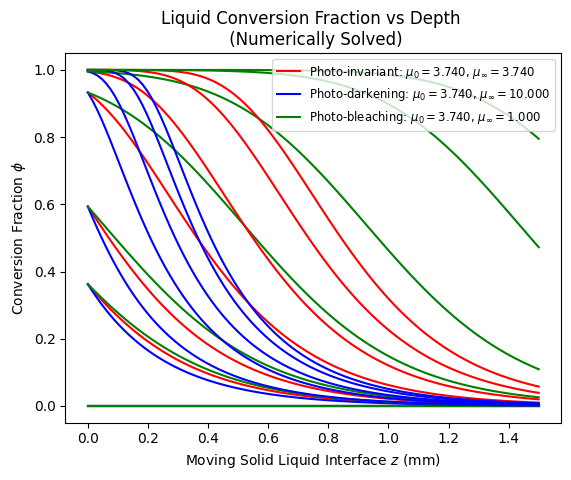

In [11]:

if not(plot_surface_boolean):
    
    fig1, ax1 = plt.subplots()

    'Make labels that automatically update for 2D plots'
    m1 = μ1_0
    minf = μ1_infny
    #change decimal places with '3f' after the dot, to change the decimal places
    label_1 = "Photo-invariant: " + "$\mu{}_0 = " + f"{m1:.3f}" + "$, $\mu{}_{\infty} = "+ f"{minf:.3f}" + "$"
    m2 = μ_0
    minf2 = μ_infny
    label_2 = "Photo-darkening: " + "$\mu{}_0 = " + f"{m2:.3f}" + "$, $\mu{}_{\infty} = "+ f"{minf2:.3f}" + "$"
    m3 = μ2_0 
    minf3 = μ2_infny 
    label_3 = "Photo-bleaching: " + "$\mu{}_0 = " + f"{m3:.3f}" + "$, $\mu{}_{\infty} = "+ f"{minf3:.3f}" + "$"
    
    'Make 2D plots for labels'
    ax1.plot(z, sol_m1.y[:, 0],'r-',label= label_1)
    ax1.plot(z, sol_m2.y[:, 0],'b-',label= label_2)
    ax1.plot(z, sol_m3.y[:, 0],'g-',label= label_3)
    #in subplots the position of the legend must be specified to work
    ax1.legend(loc="upper right")


    
    plt.legend(loc='best')
    
    'Make different curves for increments of time doubled, starting at 300s up to 10800s'
    'Makes vector of time increments to be read'
    #time_red = np.arange(0,time_stop, 300)
    time_red = [0, 300, 600, 1800, 3600, 7200, 10800]
    for time_x in time_red:
        ax1.plot(z, sol_m1.sol(time_x),'r-')
        ax1.plot(z, sol_m2.sol(time_x),'b-')
        ax1.plot(z, sol_m3.sol(time_x),'g-')
    
    ax1.set_ylabel("Conversion Fraction $\phi{}$")
    ax1.set_xlabel("Moving Solid Liquid Interface $z$ (mm)")
    ax1.set_title("Liquid Conversion Fraction vs Depth \n (Numerically Solved)")
    ax1.legend(loc="upper right",fontsize = 'small')
    plt.show()
    #print(sol_m1)
    #sol_m2 
    

'Make surface PLot'

In [12]:
if plot_surface_boolean:
    
    fig, ax1 = plt.subplots(subplot_kw={"projection":"3d"})
    time_mesh, z_mesh  = np.meshgrid(sol_m2.t,z)
    'cm.RdBu is the color gradient of the surface'
    surf = ax1.plot_surface(time_mesh, z_mesh, sol_m2.y, cmap = cm.RdBu)
    ax1.set_xlabel("Time $t$")
    ax1.set_ylabel("Moving Solid Liquid Interface $z$ (mm)")
    ax1.set_zlabel("Conversion Fraction $  \phi{} $")
    ax1.set_xlim(0.0, time_stop)
    ax1.legend(loc="upper right")
    plt.show()